# Import

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pickle

# Chargement des données

In [19]:
# Chargement des données
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    return data, labels

def load_cifar10_data():
    X_train = []
    y_train = []

    for i in range(1, 6):
        data_batch, labels_batch = load_cifar10_batch(f'DatasetCIFAR10/data_batch_{i}')
        X_train.append(data_batch)
        y_train.extend(labels_batch)

    X_train = np.concatenate(X_train)
    y_train = np.array(y_train)

    X_test, y_test = load_cifar10_batch('DatasetCIFAR10/test_batch')
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

In [20]:
X_train, y_train, X_test, y_test = load_cifar10_data()

# Traitement des données

In [21]:
# Normalisation des données
X_train = X_train / 255.0
X_test = X_test / 255.0

# Conversion en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders

In [22]:
# Création de l'ensemble de validation
train_size = int(0.8 * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size

train_dataset, val_dataset = random_split(
    TensorDataset(X_train_tensor, y_train_tensor), 
    [train_size, val_size]
)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Réseau de Neurones

In [23]:
# Définition du réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [24]:
model = SimpleNN()

# Optimiseur

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fonction de perte

In [26]:
criterion = nn.CrossEntropyLoss()

# Entraînement

In [27]:
epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/20, Train Loss: 1.8999, Val Loss: 1.7506, Val Accuracy: 0.3765
Epoch 2/20, Train Loss: 1.7195, Val Loss: 1.6971, Val Accuracy: 0.3978
Epoch 3/20, Train Loss: 1.6472, Val Loss: 1.7097, Val Accuracy: 0.3900
Epoch 4/20, Train Loss: 1.6007, Val Loss: 1.6353, Val Accuracy: 0.4163
Epoch 5/20, Train Loss: 1.5629, Val Loss: 1.5917, Val Accuracy: 0.4338
Epoch 6/20, Train Loss: 1.5339, Val Loss: 1.5624, Val Accuracy: 0.4502
Epoch 7/20, Train Loss: 1.5078, Val Loss: 1.5395, Val Accuracy: 0.4619
Epoch 8/20, Train Loss: 1.4858, Val Loss: 1.5310, Val Accuracy: 0.4570
Epoch 9/20, Train Loss: 1.4682, Val Loss: 1.5601, Val Accuracy: 0.4567
Epoch 10/20, Train Loss: 1.4564, Val Loss: 1.5277, Val Accuracy: 0.4617
Epoch 11/20, Train Loss: 1.4422, Val Loss: 1.5175, Val Accuracy: 0.4622
Epoch 12/20, Train Loss: 1.4247, Val Loss: 1.5271, Val Accuracy: 0.4544
Epoch 13/20, Train Loss: 1.4139, Val Loss: 1.4912, Val Accuracy: 0.4768
Epoch 14/20, Train Loss: 1.3938, Val Loss: 1.5630, Val Accuracy: 0.4484
E

# Visualisation de l'entraînement

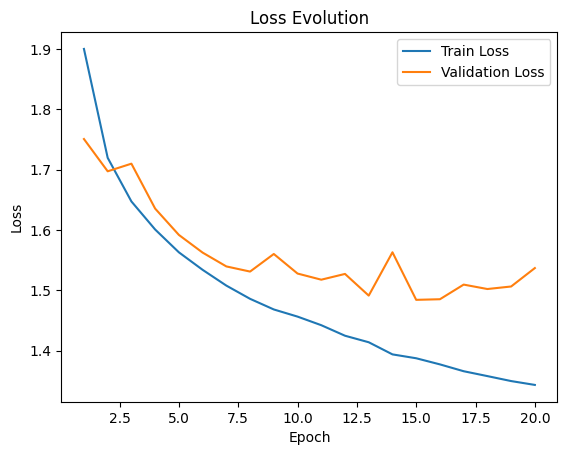

In [28]:
# Graphiques de l'évolution de l'entraînement
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Evolution")
plt.show()

# Visualisation Précision Validation

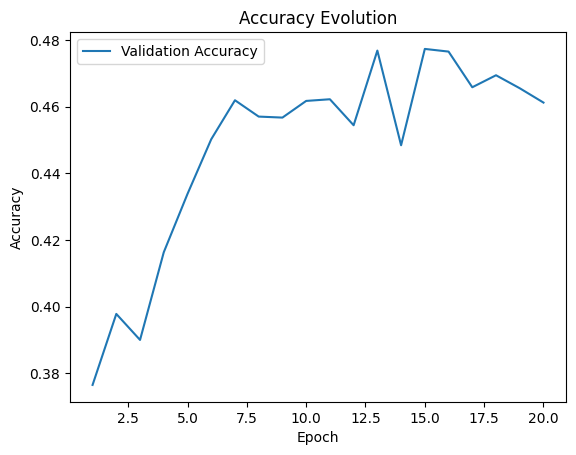

In [29]:
plt.figure()
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Evolution")
plt.show()

# Evaluation du réseau de neurones

In [32]:
# Évaluation finale sur l'ensemble de test
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.4598
